In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import mlts

import altair as alt
alt.renderers.enable('notebook')

## Load data

In [2]:
data = mlts.io.merge([
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv')
])

In [3]:
mlts.io.check(data)

In [4]:
K = len(data.iloc[:, 0].value_counts())
ds_train, ds_dev, ds_test, mu, sigma = \
    mlts.io.normalize(mlts.io.split(data, ycol=0, shape=(35968), seed=1))

## Implement the model

In [5]:
class FasionMNISTAdapter(mlts.tf.ModelAdapter):
    def __init__(self, *args, **kwargs):
        super(FasionMNISTAdapter, self).__init__(*args, **kwargs)

    @staticmethod
    def build_model(options, hparams = {}, metrics = []):
        regularization = None
        if "lambda" in hparams:
            regularization = tf.keras.regularizers.l2(l=hparams["lambda"])

        model = tf.keras.models.Sequential([
            ## The reason of using 'InputLayer' is only to
            ## show up a shape of each layer in `model.summary()`.
            tf.keras.layers.InputLayer(input_shape=(784)),
            tf.keras.layers.Dense(
                16,
                activation=tf.nn.relu,
                kernel_initializer=tf.keras.initializers.he_uniform(options["seed"]),
                kernel_regularizer=regularization,
            ),
            tf.keras.layers.Dense(
                16,
                activation=tf.nn.relu,
                kernel_initializer=tf.keras.initializers.he_uniform(options["seed"]),
                kernel_regularizer=regularization,
            ),
            tf.keras.layers.Dense(
                K,
                activation=tf.nn.softmax,
                kernel_initializer=tf.keras.initializers.he_uniform(options["seed"]),
                kernel_regularizer=regularization,
            )
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hparams.get("alpha", 0.001),
                beta_1=hparams.get("beta_1", 0.9),
                beta_2=hparams.get("beta_2", 0.999),
            ),
            loss='sparse_categorical_crossentropy',
            metrics=metrics,
        )
        
        return model
    
    @staticmethod
    def estimate_parameters(options, model, ds, callbacks=[]):
        mlts.tf.ModelAdapter.verify_options(options)
        if options["seed"] != None: tf.random.set_seed(options["seed"])
        model.fit(
            tf.data.Dataset.from_tensor_slices(ds).batch(options["batch_size"]),
            epochs=options["epochs"],
            shuffle=False,
            callbacks=callbacks,
            verbose=options["verbose"],
        )
        
        return model

In [6]:
model = FasionMNISTAdapter.build_model({"seed": 1})
model.build(ds_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


## Analyze the dataset

W0806 11:43:49.535557 4569732544 deprecation.py:323] From /Users/manifest/projects/github/machine-learning-notebook/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


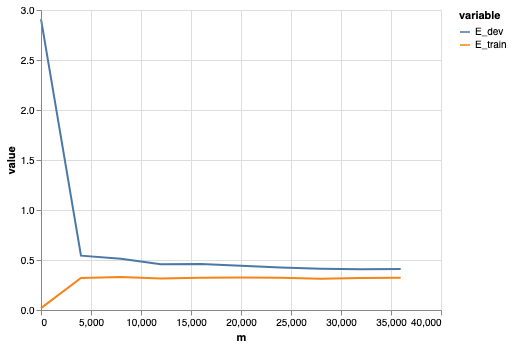

In [7]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1})
m_hist = ad.analyze_dataset(ds_train, ds_dev)
alt.Chart(m_hist.melt(id_vars="m")).mark_line().encode(
    x = "m",
    y = "value",
    color = "variable"
)

## Evaluate the model

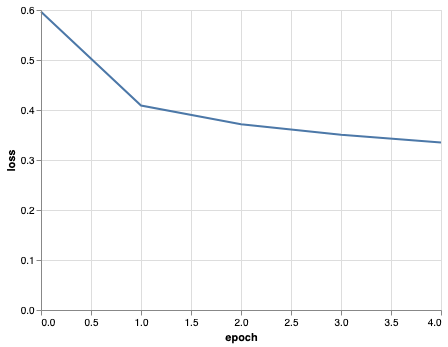

In [8]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1}, metrics=["accuracy"])
ad.fit(ds_train)
alt.Chart(ad.metrics_history().reset_index()).mark_line().encode(
    x = "epoch",
    y = "loss",
)

In [9]:
ad.generalized_metrics(ds_dev, ds_test)

,train,dev,test
loss,0.334776,0.411120,0.411569
accuracy,0.878892,0.856124,0.856870


## Tune hyperparameters

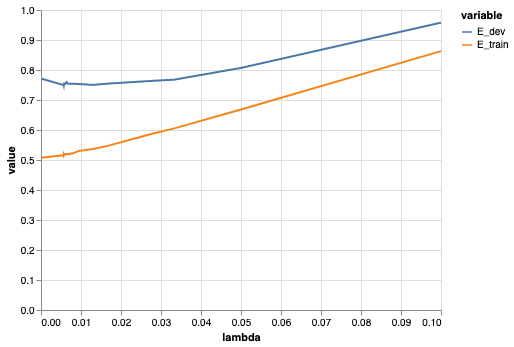

In [10]:
ad = FasionMNISTAdapter({"epochs": 5, "seed": 1})
_, lambda_hist = ad.tune_hyperparameters(
    mlts.tf.LambdaRangeGenerator(start=0.000001, stop=0.1),
    mlts.io.slice(ds_train, 0, 1024),
    ds_dev,
)
alt.Chart(lambda_hist.melt(id_vars="lambda")).mark_line().encode(
    x = "lambda",
    y = "value",
    color = "variable"
)

In [11]:
pd.DataFrame(ad.hparams, index=["hparam"])[["lambda"]].transpose()

,hparam
lambda,0.005694


## Estimate the generalized error

In [12]:
ad = FasionMNISTAdapter({"epochs": 10, "seed": 1}, hparams=ad.hparams, metrics=["accuracy"])

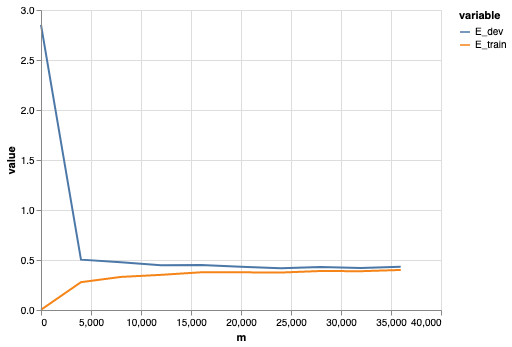

In [13]:
m_hist = ad.analyze_dataset(ds_train, ds_dev)
alt.Chart(m_hist.melt(id_vars="m")).mark_line().encode(
    x = "m",
    y = "value",
    color = "variable"
)

In [14]:
pd.DataFrame(ad.hparams, index=["hparam"]).transpose()

,hparam
lambda,0.005694


In [15]:
ad.fit(ds_train)
ad.model.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_372 (Dense)            (None, 16)                12560     
_________________________________________________________________
dense_373 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_374 (Dense)            (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


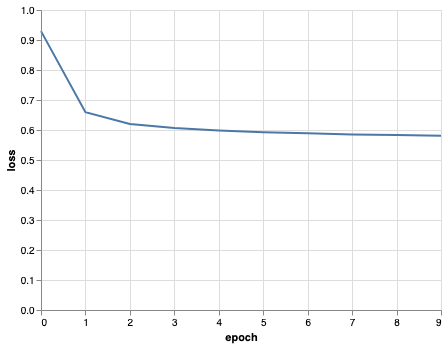

In [16]:
alt.Chart(ad.metrics_history().reset_index()).mark_line().encode(
    x = "epoch",
    y = "loss",
)

In [17]:
ad.generalized_metrics(ds_dev, ds_test)

,train,dev,test
loss,0.581119,0.605190,0.609804
accuracy,0.856122,0.842027,0.843519
